<a href="https://colab.research.google.com/github/paolala24/aprendizaje_maquinas/blob/main/Talleres/pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1.Instalación de dependencias:
### Prompt 1:

Quiero comenzar un ejercicio de aprendizaje por refuerzo continuo utilizando el entorno Pendulum-v1 de Gymnasium junto con la librería TF-Agents. Para ello, necesito que primero instales las dependencias necesarias, incluyendo tf-agents[reverb] y gymnasium[classic-control]. Luego, importa todas las librerías relevantes para trabajar con TF-Agents, TensorFlow, NumPy, Matplotlib y Gym. A continuación, carga el entorno Pendulum-v1 usando suite_gym de TF-Agents para obtener dos entornos: uno para entrenamiento y otro para evaluación, y conviértelos a objetos TFPyEnvironment. También quiero que imprimas la especificación de observaciones y acciones del entorno de entrenamiento para verificar que todo está funcionando correctamente. Además, crea un entorno adicional usando Gymnasium (con render_mode="rgb_array") solo para visualización, y define una función llamada plot_environment() que renderice una imagen del entorno y la muestre usando Matplotlib. Por favor, organiza el código resultante en celdas, como si fuera a ejecutarse en un entorno tipo Jupyter Notebook o Kaggle.

In [2]:
!pip install tf-agents[reverb] gymnasium[classic-control]


## 2.Importación de Librerias y Creacion del entorno

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment

import gymnasium as gym

# Nombre del entorno
env_name = "Pendulum-v1"

# Cargar entornos en modo Python (no-TensorFlow)
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# Convertir a entornos compatibles con TensorFlow (TFPyEnvironment)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Mostrar especificaciones de observación y acción
print("Especificación de observaciones:")
print(train_env.observation_spec())

print("\nEspecificación de acciones:")
print(train_env.action_spec())

Especificación de observaciones:
BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='observation', minimum=array([-1., -1., -8.], dtype=float32), maximum=array([1., 1., 8.], dtype=float32))

Especificación de acciones:
BoundedTensorSpec(shape=(1,), dtype=tf.float32, name='action', minimum=array(-2., dtype=float32), maximum=array(2., dtype=float32))


## 3.Entorno para visualización y función de renderizado

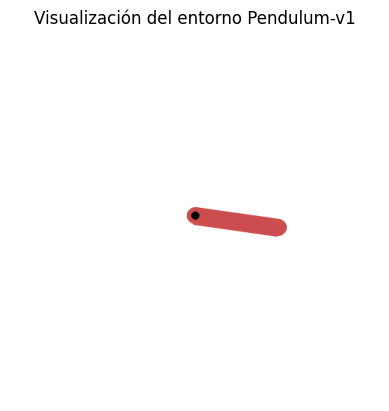

In [4]:
# Crear entorno para visualización con modo gráfico
render_env = gym.make(env_name, render_mode="rgb_array")

# Función de visualización con Matplotlib
def plot_environment():
    obs, _ = render_env.reset()
    img = render_env.render()
    plt.imshow(img)
    plt.axis('off')
    plt.title("Visualización del entorno Pendulum-v1")
    plt.show()

# Ejecutar visualización una vez
plot_environment()


## 4.Definición de hiperparametros para DDPG

### Prompt 2:
Ahora necesito que definas los hiperparametros necesarios para entrenar un agente de DDPG en el entorno Pendulum-v1, usando TF-agents.

In [5]:
# -------------------------------------
# Parámetros globales de entrenamiento
# -------------------------------------
num_iterations = 100_000                # Número total de iteraciones de entrenamiento
initial_collect_steps = 1000            # Pasos de recolección antes del entrenamiento
collect_steps_per_iteration = 1         # Pasos de recolección por iteración
replay_buffer_capacity = 100_000        # Capacidad del buffer de replay

batch_size = 64                         # Tamaño del batch para entrenamiento
critic_learning_rate = 1e-3             # Tasa de aprendizaje del crítico
actor_learning_rate = 1e-4              # Tasa de aprendizaje del actor

log_interval = 200                      # Frecuencia de impresión de logs
eval_interval = 1000                    # Frecuencia de evaluación
num_eval_episodes = 10                  # Número de episodios de evaluación

# -------------------------------------
# Parámetros de redes objetivo (target)
# -------------------------------------
tau = 0.005                             # Parámetro de actualización suave (soft update)
gamma = 0.99                            # Factor de descuento (reward discount)

# -------------------------------------
# Arquitectura de redes
# -------------------------------------
actor_fc_layers = (400, 300)           # Capas ocultas del actor
critic_obs_fc_layers = ()              # Capas para observaciones en el crítico (ninguna adicional)
critic_action_fc_layers = ()           # Capas para acciones en el crítico (ninguna adicional)
critic_joint_fc_layers = (400, 300)    # Capas conjuntas observación-acción en el crítico

# -------------------------------------
# Parámetros de ruido Ornstein-Uhlenbeck para exploración
# -------------------------------------
ou_stddev = 0.2                         # Desviación estándar del ruido OU
ou_damping = 0.15                       # Término de amortiguamiento


## 5. Definición de las redes Actor y Crítica
### Prompt 3:
Sigue definiendo las redes neuronales necesarias para un agente DDPG (DdpgAgent) en el entorno Pendulum-v1 usando TF-Agents. Luego, define una red crítica que reciba como entrada una tupla (observación, acción). Usa los tamaños de capa definidos en los hiperparámetros. Al final, imprime una verificación que confirme que las redes fueron creadas correctamente.

In [6]:
from tf_agents.agents.ddpg.actor_network import ActorNetwork
from tf_agents.agents.ddpg.critic_network import CriticNetwork
from tf_agents.networks import utils
from tf_agents.specs import tensor_spec

# -------------------------------------
# Especificaciones de entrada/salida
# -------------------------------------
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()
time_step_spec = train_env.time_step_spec()

# -------------------------------------
# Red Actor: mapea observaciones → acciones
# -------------------------------------
actor_net = ActorNetwork(
    input_tensor_spec=observation_spec,
    output_tensor_spec=action_spec,
    fc_layer_params=actor_fc_layers,
    activation_fn=tf.keras.activations.relu,
    name="ActorNetwork"
)

# -------------------------------------
# Red Crítica: mapea (observación, acción) → Q(s, a)
# -------------------------------------
critic_net = CriticNetwork(
    input_tensor_spec=(observation_spec, action_spec),
    observation_fc_layer_params=critic_obs_fc_layers,
    action_fc_layer_params=critic_action_fc_layers,
    joint_fc_layer_params=critic_joint_fc_layers,
    activation_fn=tf.keras.activations.relu,
    name="CriticNetwork"
)

# -------------------------------------
# Verificación
# -------------------------------------
print("✅ Red Actor creada:", isinstance(actor_net, ActorNetwork))
print("✅ Red Crítico creada:", isinstance(critic_net, CriticNetwork))


✅ Red Actor creada: True
✅ Red Crítico creada: True


## 6. Creación del agente DDPG (DdpgAgent)
### Prompt 4:
Ahora quiero que sigas con la creación del agente DdopgAgent usando estas redes creadas.

In [7]:
from tf_agents.agents.ddpg.ddpg_agent import DdpgAgent
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common

# -------------------------------------
# Inicializadores (optimizers)
# -------------------------------------
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=actor_learning_rate)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=critic_learning_rate)

# -------------------------------------
# Agente DDPG
# -------------------------------------
ddpg_agent = DdpgAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=action_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=actor_optimizer,
    critic_optimizer=critic_optimizer,
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_update_tau=tau,
    target_update_period=1,
    gamma=gamma,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    train_step_counter=tf.Variable(0)
)

# Inicializar el agente (compilar redes y variables)
ddpg_agent.initialize()

# Confirmación
print("✅ Agente DDPG creado y listo para entrenamiento.")


✅ Agente DDPG creado y listo para entrenamiento.


## 7. Replay Buffer y Política de Recolección

In [8]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

# -------------------------------------
# Replay Buffer: para almacenar transiciones (s, a, r, s')
# -------------------------------------
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=ddpg_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity
)

# -------------------------------------
# Política de recolección (usa directamente la del agente DDPG con OU ya incluido)
# -------------------------------------
collect_policy = ddpg_agent.collect_policy

# -------------------------------------
# Confirmación
# -------------------------------------
print("✅ Replay Buffer inicializado con capacidad =", replay_buffer_capacity)
print("✅ Política de recolección (con OU) del agente configurada.")


✅ Replay Buffer inicializado con capacidad = 100000
✅ Política de recolección (con OU) del agente configurada.


## 8. Driver para la recolección inicial de datos

In [9]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.metrics import tf_metrics
from tf_agents.trajectories import trajectory

# -------------------------------------
# Métricas opcionales de recolección
# -------------------------------------
env_steps_metric = tf_metrics.EnvironmentSteps()
avg_return_metric = tf_metrics.AverageReturnMetric()

# -------------------------------------
# Driver para recolección de pasos (experiencias iniciales)
# -------------------------------------
initial_collect_driver = DynamicStepDriver(
    env=train_env,
    policy=collect_policy,
    observers=[replay_buffer.add_batch, env_steps_metric],
    num_steps=initial_collect_steps
)

# Ejecutar recolección inicial
initial_collect_driver.run()

print(f"✅ Recolección inicial completada con {initial_collect_steps} pasos.")


✅ Recolección inicial completada con 1000 pasos.


## 9. Entrenamiento del agente DDPG

In [10]:
from tf_agents.utils.common import function
from tqdm import trange

# -------------------------------------
# Dataset del buffer para muestreo
# -------------------------------------
dataset = replay_buffer.as_dataset(
    num_parallel_calls=tf.data.AUTOTUNE,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(tf.data.AUTOTUNE)

iterator = iter(dataset)

# -------------------------------------
# Entrenamiento en modo tf.function
# -------------------------------------
ddpg_agent.train = function(ddpg_agent.train)

# -------------------------------------
# Métricas para seguimiento
# -------------------------------------
train_rewards = []

print("🚀 Entrenando agente DDPG...\n")

for step in trange(num_iterations):
    # Recolectar nuevos pasos
    time_step = train_env.current_time_step()
    action = collect_policy.action(time_step)
    next_time_step = train_env.step(action.action)
    traj = trajectory.from_transition(time_step, action, next_time_step)
    replay_buffer.add_batch(traj)

    # Entrenar con muestra del buffer
    experience, _ = next(iterator)
    train_loss = ddpg_agent.train(experience).loss

    # Evaluación periódica
    if step % eval_interval == 0:
        total_return = 0.0
        for _ in range(num_eval_episodes):
            time_step = eval_env.reset()
            episode_return = 0.0
            while not time_step.is_last():
                action = ddpg_agent.policy.action(time_step)
                time_step = eval_env.step(action.action)
                episode_return += time_step.reward.numpy()[0]
            total_return += episode_return
        avg_return = total_return / num_eval_episodes
        train_rewards.append(avg_return)
        print(f"Iteración {step}: Recompensa promedio = {avg_return:.2f}")


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


🚀 Entrenando agente DDPG...



  0%|          | 5/100000 [00:23<95:57:05,  3.45s/it] 

Iteración 0: Recompensa promedio = -1243.74


  1%|          | 1005/100000 [01:12<34:54:58,  1.27s/it]

Iteración 1000: Recompensa promedio = -1485.14


  2%|▏         | 2005/100000 [02:01<27:49:52,  1.02s/it]

Iteración 2000: Recompensa promedio = -1146.06


  3%|▎         | 3006/100000 [02:48<28:22:15,  1.05s/it]

Iteración 3000: Recompensa promedio = -750.86


  4%|▍         | 4006/100000 [03:36<33:24:27,  1.25s/it]

Iteración 4000: Recompensa promedio = -1008.17


  5%|▌         | 5006/100000 [04:25<25:18:08,  1.04it/s]

Iteración 5000: Recompensa promedio = -176.67


  6%|▌         | 6006/100000 [05:12<24:16:30,  1.08it/s]

Iteración 6000: Recompensa promedio = -151.79


  7%|▋         | 7004/100000 [06:00<34:33:01,  1.34s/it]

Iteración 7000: Recompensa promedio = -152.88


  8%|▊         | 8005/100000 [06:47<28:22:33,  1.11s/it]

Iteración 8000: Recompensa promedio = -133.52


  9%|▉         | 9006/100000 [07:34<22:50:06,  1.11it/s]

Iteración 9000: Recompensa promedio = -131.77


 10%|█         | 10006/100000 [08:22<26:42:26,  1.07s/it]

Iteración 10000: Recompensa promedio = -190.29


 11%|█         | 11005/100000 [09:09<24:45:11,  1.00s/it]

Iteración 11000: Recompensa promedio = -138.59


 12%|█▏        | 12005/100000 [09:58<30:57:08,  1.27s/it]

Iteración 12000: Recompensa promedio = -158.54


 13%|█▎        | 13006/100000 [10:47<33:44:55,  1.40s/it]

Iteración 13000: Recompensa promedio = -145.58


 14%|█▍        | 14006/100000 [11:34<26:41:47,  1.12s/it]

Iteración 14000: Recompensa promedio = -147.58


 15%|█▌        | 15006/100000 [12:22<21:58:33,  1.07it/s]

Iteración 15000: Recompensa promedio = -74.76


 16%|█▌        | 16006/100000 [13:08<24:03:13,  1.03s/it]

Iteración 16000: Recompensa promedio = -162.15


 17%|█▋        | 17005/100000 [13:56<26:18:32,  1.14s/it]

Iteración 17000: Recompensa promedio = -170.47


 18%|█▊        | 18005/100000 [14:43<25:00:59,  1.10s/it]

Iteración 18000: Recompensa promedio = -182.24


 19%|█▉        | 19005/100000 [15:32<23:59:30,  1.07s/it]

Iteración 19000: Recompensa promedio = -124.55


 20%|██        | 20005/100000 [16:27<28:26:06,  1.28s/it]

Iteración 20000: Recompensa promedio = -156.48


 21%|██        | 21005/100000 [17:15<20:53:53,  1.05it/s]

Iteración 21000: Recompensa promedio = -121.41


 22%|██▏       | 22006/100000 [18:01<22:40:34,  1.05s/it]

Iteración 22000: Recompensa promedio = -128.26


 23%|██▎       | 23006/100000 [18:49<22:38:14,  1.06s/it]

Iteración 23000: Recompensa promedio = -165.34


 24%|██▍       | 24006/100000 [19:35<21:05:49,  1.00it/s]

Iteración 24000: Recompensa promedio = -48.55


 25%|██▌       | 25006/100000 [20:21<19:41:02,  1.06it/s]

Iteración 25000: Recompensa promedio = -95.31


 26%|██▌       | 26005/100000 [21:07<19:59:22,  1.03it/s]

Iteración 26000: Recompensa promedio = -163.04


 27%|██▋       | 27004/100000 [21:53<24:02:09,  1.19s/it]

Iteración 27000: Recompensa promedio = -120.65


 28%|██▊       | 28006/100000 [22:38<22:40:50,  1.13s/it]

Iteración 28000: Recompensa promedio = -167.34


 29%|██▉       | 29006/100000 [23:23<17:01:58,  1.16it/s]

Iteración 29000: Recompensa promedio = -98.80


 30%|███       | 30006/100000 [24:08<19:14:30,  1.01it/s]

Iteración 30000: Recompensa promedio = -145.73


 31%|███       | 31006/100000 [24:54<18:43:56,  1.02it/s]

Iteración 31000: Recompensa promedio = -133.24


 32%|███▏      | 32004/100000 [25:39<21:03:54,  1.12s/it]

Iteración 32000: Recompensa promedio = -131.83


 33%|███▎      | 33006/100000 [26:27<27:31:08,  1.48s/it]

Iteración 33000: Recompensa promedio = -158.88


 34%|███▍      | 34006/100000 [27:13<17:06:37,  1.07it/s]

Iteración 34000: Recompensa promedio = -158.76


 35%|███▌      | 35006/100000 [27:58<15:30:30,  1.16it/s]

Iteración 35000: Recompensa promedio = -178.53


 36%|███▌      | 36005/100000 [28:44<17:02:54,  1.04it/s]

Iteración 36000: Recompensa promedio = -170.30


 37%|███▋      | 37005/100000 [29:29<16:18:49,  1.07it/s]

Iteración 37000: Recompensa promedio = -135.37


 38%|███▊      | 38006/100000 [30:14<22:04:34,  1.28s/it]

Iteración 38000: Recompensa promedio = -154.54


 39%|███▉      | 39006/100000 [31:00<17:34:12,  1.04s/it]

Iteración 39000: Recompensa promedio = -179.40


 40%|████      | 40006/100000 [31:45<14:35:23,  1.14it/s]

Iteración 40000: Recompensa promedio = -182.30


 41%|████      | 41006/100000 [32:31<16:50:00,  1.03s/it]

Iteración 41000: Recompensa promedio = -168.10


 42%|████▏     | 42004/100000 [33:17<19:13:51,  1.19s/it]

Iteración 42000: Recompensa promedio = -134.74


 43%|████▎     | 43006/100000 [34:03<18:47:15,  1.19s/it]

Iteración 43000: Recompensa promedio = -157.99


 44%|████▍     | 44006/100000 [34:50<16:34:07,  1.07s/it]

Iteración 44000: Recompensa promedio = -185.28


 45%|████▌     | 45004/100000 [35:37<15:21:26,  1.01s/it]

Iteración 45000: Recompensa promedio = -169.78


 46%|████▌     | 46006/100000 [36:24<13:51:19,  1.08it/s]

Iteración 46000: Recompensa promedio = -155.03


 47%|████▋     | 47006/100000 [37:12<13:44:35,  1.07it/s]

Iteración 47000: Recompensa promedio = -102.32


 48%|████▊     | 48005/100000 [37:59<13:59:25,  1.03it/s]

Iteración 48000: Recompensa promedio = -167.44


 49%|████▉     | 49004/100000 [38:46<15:57:01,  1.13s/it]

Iteración 49000: Recompensa promedio = -132.17


 50%|█████     | 50006/100000 [39:32<16:57:42,  1.22s/it]

Iteración 50000: Recompensa promedio = -110.15


 51%|█████     | 51005/100000 [40:21<17:19:37,  1.27s/it]

Iteración 51000: Recompensa promedio = -154.82


 52%|█████▏    | 52006/100000 [41:08<12:01:01,  1.11it/s]

Iteración 52000: Recompensa promedio = -130.98


 53%|█████▎    | 53006/100000 [41:55<12:33:47,  1.04it/s]

Iteración 53000: Recompensa promedio = -98.20


 54%|█████▍    | 54005/100000 [42:40<14:06:46,  1.10s/it]

Iteración 54000: Recompensa promedio = -143.94


 55%|█████▌    | 55004/100000 [43:25<11:47:04,  1.06it/s]

Iteración 55000: Recompensa promedio = -129.50


 56%|█████▌    | 56006/100000 [44:10<13:59:00,  1.14s/it]

Iteración 56000: Recompensa promedio = -165.62


 57%|█████▋    | 57005/100000 [44:57<11:25:39,  1.05it/s]

Iteración 57000: Recompensa promedio = -146.62


 58%|█████▊    | 58006/100000 [45:43<10:36:34,  1.10it/s]

Iteración 58000: Recompensa promedio = -130.28


 59%|█████▉    | 59006/100000 [46:30<13:06:26,  1.15s/it]

Iteración 59000: Recompensa promedio = -159.65


 60%|██████    | 60006/100000 [47:17<10:47:41,  1.03it/s]

Iteración 60000: Recompensa promedio = -149.11


 61%|██████    | 61004/100000 [48:04<12:30:21,  1.15s/it]

Iteración 61000: Recompensa promedio = -164.89


 62%|██████▏   | 62008/100000 [48:50<12:07:01,  1.15s/it]

Iteración 62000: Recompensa promedio = -109.41


 63%|██████▎   | 63006/100000 [49:36<9:42:54,  1.06it/s] 

Iteración 63000: Recompensa promedio = -117.07


 64%|██████▍   | 64006/100000 [50:21<10:07:11,  1.01s/it]

Iteración 64000: Recompensa promedio = -130.34


 65%|██████▌   | 65006/100000 [51:08<11:14:28,  1.16s/it]

Iteración 65000: Recompensa promedio = -169.49


 66%|██████▌   | 66006/100000 [51:55<8:39:25,  1.09it/s] 

Iteración 66000: Recompensa promedio = -150.08


 67%|██████▋   | 67007/100000 [52:40<7:35:59,  1.21it/s] 

Iteración 67000: Recompensa promedio = -133.09


 68%|██████▊   | 68006/100000 [53:26<7:52:55,  1.13it/s] 

Iteración 68000: Recompensa promedio = -110.99


 69%|██████▉   | 69005/100000 [54:13<8:29:21,  1.01it/s] 

Iteración 69000: Recompensa promedio = -121.23


 70%|███████   | 70005/100000 [55:00<8:30:52,  1.02s/it] 

Iteración 70000: Recompensa promedio = -182.93


 71%|███████   | 71005/100000 [55:48<11:26:10,  1.42s/it]

Iteración 71000: Recompensa promedio = -128.48


 72%|███████▏  | 72006/100000 [56:36<7:51:55,  1.01s/it] 

Iteración 72000: Recompensa promedio = -129.40


 73%|███████▎  | 73006/100000 [57:24<9:22:40,  1.25s/it] 

Iteración 73000: Recompensa promedio = -139.30


 74%|███████▍  | 74004/100000 [58:11<7:59:06,  1.11s/it] 

Iteración 74000: Recompensa promedio = -146.40


 75%|███████▌  | 75006/100000 [58:59<8:17:09,  1.19s/it] 

Iteración 75000: Recompensa promedio = -116.64


 76%|███████▌  | 76006/100000 [59:47<6:44:51,  1.01s/it] 

Iteración 76000: Recompensa promedio = -116.94


 77%|███████▋  | 77006/100000 [1:00:34<5:44:18,  1.11it/s]

Iteración 77000: Recompensa promedio = -96.24


 78%|███████▊  | 78006/100000 [1:01:21<5:15:24,  1.16it/s]

Iteración 78000: Recompensa promedio = -171.94


 79%|███████▉  | 79005/100000 [1:02:08<8:40:05,  1.49s/it] 

Iteración 79000: Recompensa promedio = -133.99


 80%|████████  | 80006/100000 [1:02:55<5:09:36,  1.08it/s]

Iteración 80000: Recompensa promedio = -128.63


 81%|████████  | 81005/100000 [1:03:42<5:20:26,  1.01s/it]

Iteración 81000: Recompensa promedio = -548.27


 82%|████████▏ | 82006/100000 [1:04:28<6:39:19,  1.33s/it] 

Iteración 82000: Recompensa promedio = -104.93


 83%|████████▎ | 83006/100000 [1:05:15<4:33:39,  1.04it/s]

Iteración 83000: Recompensa promedio = -155.39


 84%|████████▍ | 84004/100000 [1:06:02<4:43:28,  1.06s/it]

Iteración 84000: Recompensa promedio = -100.59


 85%|████████▌ | 85005/100000 [1:06:50<5:01:19,  1.21s/it]

Iteración 85000: Recompensa promedio = -231.09


 86%|████████▌ | 86006/100000 [1:07:38<4:57:14,  1.27s/it]

Iteración 86000: Recompensa promedio = -177.60


 87%|████████▋ | 87006/100000 [1:08:26<3:51:32,  1.07s/it]

Iteración 87000: Recompensa promedio = -173.79


 88%|████████▊ | 88006/100000 [1:09:14<3:09:54,  1.05it/s]

Iteración 88000: Recompensa promedio = -158.62


 89%|████████▉ | 89005/100000 [1:10:00<3:10:51,  1.04s/it]

Iteración 89000: Recompensa promedio = -110.26


 90%|█████████ | 90005/100000 [1:10:47<2:59:21,  1.08s/it]

Iteración 90000: Recompensa promedio = -134.30


 91%|█████████ | 91006/100000 [1:11:34<2:25:01,  1.03it/s]

Iteración 91000: Recompensa promedio = -145.86


 92%|█████████▏| 92004/100000 [1:12:21<2:32:50,  1.15s/it]

Iteración 92000: Recompensa promedio = -90.55


 93%|█████████▎| 93006/100000 [1:13:09<2:37:59,  1.36s/it]

Iteración 93000: Recompensa promedio = -181.35


 94%|█████████▍| 94006/100000 [1:13:56<1:47:15,  1.07s/it]

Iteración 94000: Recompensa promedio = -132.00


 95%|█████████▌| 95004/100000 [1:14:43<1:41:34,  1.22s/it]

Iteración 95000: Recompensa promedio = -196.73


 96%|█████████▌| 96005/100000 [1:15:28<1:18:43,  1.18s/it]

Iteración 96000: Recompensa promedio = -105.19


 97%|█████████▋| 97006/100000 [1:16:14<42:53,  1.16it/s]  

Iteración 97000: Recompensa promedio = -130.01


 98%|█████████▊| 98005/100000 [1:17:00<32:59,  1.01it/s]

Iteración 98000: Recompensa promedio = -395.19


 99%|█████████▉| 99006/100000 [1:17:46<19:23,  1.17s/it]

Iteración 99000: Recompensa promedio = -159.52


100%|██████████| 100000/100000 [1:18:12<00:00, 21.31it/s]
